<a href="https://colab.research.google.com/github/dev02chandan/recommendation-systems/blob/main/User_User_Based_Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema recomendador de filtro colaborativo, basado en usuarios

Utilizaremos la similitud entre usuarios en función de sus preferencias para realizar recomendaciones.
Recordemos que como hipótesis tenemos que usuarios similares tienden a gustarle items similares.

Los pasos a seguir son los siguientes:

1. Encontrar usuarios similares en función de los ratings que han dado a los productos de la base de datos.
2. Identificar los items que usuarios similares han ranqueado alto, y los usuarios no han consumido
3. Recomendar items en función de este ranking.

In [441]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

# Datos

Usaremos el conjunto de datos de movielens con puntuaciones dadas por usuarios a películas. 

El conjunto de películas posee además un conjunto de atributos que podrían ser utilizados para determinar la similitud entre los items, pero sería otro enfoque distinto.

In [442]:
movies = pl.read_csv('../data/raw/movies/movies.csv') # Revisar la ruta en función del sistema operativo
movies

movieId,title,genres
i64,str,str
1,"""Toy Story (1995)""","""Adventure|Animation|Children|C…"
2,"""Jumanji (1995)""","""Adventure|Children|Fantasy"""
3,"""Grumpier Old Men (1995)""","""Comedy|Romance"""
4,"""Waiting to Exhale (1995)""","""Comedy|Drama|Romance"""
5,"""Father of the Bride Part II (1…","""Comedy"""
…,…,…
193581,"""Black Butler: Book of the Atla…","""Action|Animation|Comedy|Fantas…"
193583,"""No Game No Life: Zero (2017)""","""Animation|Comedy|Fantasy"""
193585,"""Flint (2017)""","""Drama"""


In [443]:
links = pl.read_csv('../data/raw/movies/links.csv')
links

movieId,imdbId,tmdbId
i64,i64,i64
1,114709,862
2,113497,8844
3,113228,15602
4,114885,31357
5,113041,11862
…,…,…
193581,5476944,432131
193583,5914996,445030
193585,6397426,479308


In [444]:
tags = pl.read_csv('../data/raw/movies/tags.csv')
tags

userId,movieId,tag,timestamp
i64,i64,str,i64
2,60756,"""funny""",1445714994
2,60756,"""Highly quotable""",1445714996
2,60756,"""will ferrell""",1445714992
2,89774,"""Boxing story""",1445715207
2,89774,"""MMA""",1445715200
…,…,…,…
606,7382,"""for katie""",1171234019
606,7936,"""austere""",1173392334
610,3265,"""gun fu""",1493843984


In [445]:
ratings = pl.read_csv('../data/raw/movies/ratings.csv')
ratings

userId,movieId,rating,timestamp
i64,i64,f64,i64
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815
1,50,5.0,964982931
…,…,…,…
610,166534,4.0,1493848402
610,168248,5.0,1493850091
610,168250,5.0,1494273047


Hay cuatro columnas en el dataset de ratings:
- userId: identificador del usuario
- movieId: identificador de la película, cuya información está en la tabla movies
- rating: puntuación dadas a la película
- timestamp: momento en el que fue realizada la puntuación 

Hay más de 100mil puntuaciones

In [446]:
ratings.describe()

statistic,userId,movieId,rating,timestamp
str,f64,f64,f64,f64
"""count""",100836.0,100836.0,100836.0,100836.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",326.127564,19435.295718,3.501557,1.2059e9
"""std""",182.618491,35530.987199,1.042529,2.1626e8
"""min""",1.0,1.0,0.5,8.28124615e8
"""25%""",177.0,1199.0,3.0,1.0191e9
"""50%""",325.0,2991.0,3.5,1.1861e9
"""75%""",477.0,8121.0,4.0,1.4360e9
"""max""",610.0,193609.0,5.0,1.5378e9


In [447]:
print(
    ratings.select(
        pl.n_unique(ratings.columns)
    )
)


shape: (1, 4)
┌────────┬─────────┬────────┬───────────┐
│ userId ┆ movieId ┆ rating ┆ timestamp │
│ ---    ┆ ---     ┆ ---    ┆ ---       │
│ u32    ┆ u32     ┆ u32    ┆ u32       │
╞════════╪═════════╪════════╪═══════════╡
│ 610    ┆ 9724    ┆ 10     ┆ 85043     │
└────────┴─────────┴────────┴───────────┘


No hay valores perdidos.

Hay 610 usuarios únicos, 9724 películas, y 10 valores distintos asignados en el rating. Veamos estos últimos.

In [448]:
(
    ratings
        .group_by(
            pl.col('rating')
        ).agg(
            pl.len()
        ).sort(by='rating')
)

rating,len
f64,u32
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


Vamos a realizar un join entre los ratings y las películas, para tener toda la información en el mismo conjunto de datos

In [449]:
df = movies.join(ratings,on='movieId')
df



movieId,title,genres,userId,rating,timestamp
i64,str,str,i64,f64,i64
1,"""Toy Story (1995)""","""Adventure|Animation|Children|C…",1,4.0,964982703
3,"""Grumpier Old Men (1995)""","""Comedy|Romance""",1,4.0,964981247
6,"""Heat (1995)""","""Action|Crime|Thriller""",1,4.0,964982224
47,"""Seven (a.k.a. Se7en) (1995)""","""Mystery|Thriller""",1,5.0,964983815
50,"""Usual Suspects, The (1995)""","""Crime|Mystery|Thriller""",1,5.0,964982931
…,…,…,…,…,…
166534,"""Split (2017)""","""Drama|Horror|Thriller""",610,4.0,1493848402
168248,"""John Wick: Chapter Two (2017)""","""Action|Crime|Thriller""",610,5.0,1493850091
168250,"""Get Out (2017)""","""Horror""",610,5.0,1494273047


# Entendimiento de los datos

Nos vamos a quedar para el análisis solo con aquellas películas que fueron ranqueadas más de 100 veces. 

In [450]:
# Aggregate by movie
agg_ratings = (
    df.group_by(
        pl.col('title')
    ).agg(
        pl.len().alias('count'),
        pl.col('rating').mean().alias('rating')
    ).filter(
        pl.col('count') > 100
    )
)
agg_ratings

title,count,rating
str,u32,f64
"""Dumb & Dumber (Dumb and Dumber…",133,3.06015
"""Crimson Tide (1995)""",103,3.635922
"""Taxi Driver (1976)""",104,4.105769
"""Silence of the Lambs, The (199…",279,4.16129
"""Waterworld (1995)""",115,2.913043
…,…,…
"""American Beauty (1999)""",204,4.056373
"""Star Wars: Episode V - The Emp…",211,4.21564
"""Dark Knight, The (2008)""",149,4.238255


In [451]:
print(f"El rating promedio de las películas es { agg_ratings['rating'].mean()}")
print(f"La cantidad de peliculas con rating mayor a 4 es { (agg_ratings['rating']>4).sum()}")
print(f"La cantidad de peliculas con rating mayor a 4.25 es { (agg_ratings['rating']>4.25).sum()}")




El rating promedio de las películas es 3.8200591733105496
La cantidad de peliculas con rating mayor a 4 es 46
La cantidad de peliculas con rating mayor a 4.25 es 5


Top 20 películas más populares:

In [452]:
agg_ratings.sort(by='rating', descending=True).head(20)


title,count,rating
str,u32,f64
"""Shawshank Redemption, The (199…",317,4.429022
"""Godfather, The (1972)""",192,4.2890625
"""Fight Club (1999)""",218,4.272936
"""Godfather: Part II, The (1974)""",129,4.25969
"""Departed, The (2006)""",107,4.252336
…,…,…
"""One Flew Over the Cuckoo's Nes…",133,4.203008
"""Reservoir Dogs (1992)""",131,4.20229
"""Pulp Fiction (1994)""",307,4.197068


Usaremos un `jointplot` para ver si existe una correlación entre la cantidad de ratings y el rating de cada película



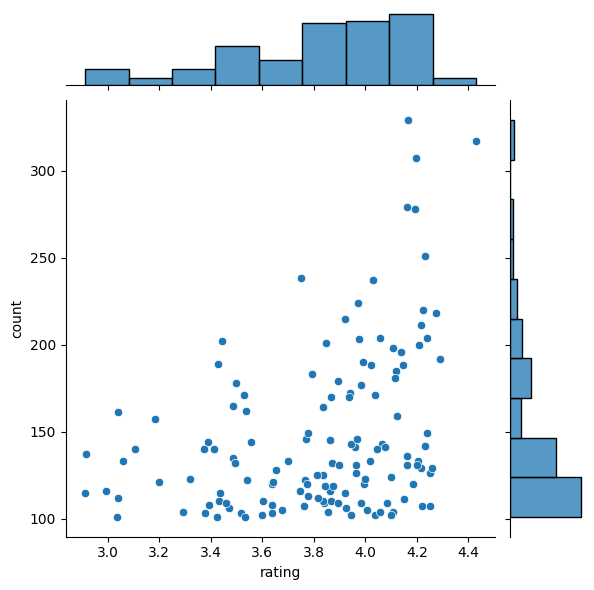

In [453]:

sns.jointplot(x='rating', y='count', data=agg_ratings)

* Hay una correlación positiva entre el rating promedio y la cantidad de puntuaciones recibidas.

* Cuantas más puntuaciones haya recibido, más alto suele ser la puntuación promedio

Quedemonos entonces solo con las peliculas con más de 100 puntuaciones

In [454]:
df100 = df.filter(
    pl.col('title').is_in(agg_ratings['title'].to_list())
)
df100

movieId,title,genres,userId,rating,timestamp
i64,str,str,i64,f64,i64
1,"""Toy Story (1995)""","""Adventure|Animation|Children|C…",1,4.0,964982703
6,"""Heat (1995)""","""Action|Crime|Thriller""",1,4.0,964982224
47,"""Seven (a.k.a. Se7en) (1995)""","""Mystery|Thriller""",1,5.0,964983815
50,"""Usual Suspects, The (1995)""","""Crime|Mystery|Thriller""",1,5.0,964982931
110,"""Braveheart (1995)""","""Action|Drama|War""",1,4.0,964982176
…,…,…,…,…,…
48516,"""Departed, The (2006)""","""Crime|Drama|Thriller""",610,5.0,1479542152
58559,"""Dark Knight, The (2008)""","""Action|Crime|Drama|IMAX""",610,4.5,1493844688
60069,"""WALL·E (2008)""","""Adventure|Animation|Children|R…",610,4.5,1493844866


In [455]:
print(
    df100.select(
        pl.n_unique(df100.columns)
    )
)


shape: (1, 6)
┌─────────┬───────┬────────┬────────┬────────┬───────────┐
│ movieId ┆ title ┆ genres ┆ userId ┆ rating ┆ timestamp │
│ ---     ┆ ---   ┆ ---    ┆ ---    ┆ ---    ┆ ---       │
│ u32     ┆ u32   ┆ u32    ┆ u32    ┆ u32    ┆ u32       │
╞═════════╪═══════╪════════╪════════╪════════╪═══════════╡
│ 134     ┆ 134   ┆ 84     ┆ 597    ┆ 10     ┆ 17217     │
└─────────┴───────┴────────┴────────┴────────┴───────────┘


Vemos que nos quedamos con 134 películas, y las puntuaciones dadas por 597 usuarios.

# Matriz de preferencias

Vamos a crear un amatriz Usuario x Película con el puntaje dado por cada usuario a cada película. Es una matriz dispersa por la que habrá muchos valores nulos.

In [456]:
# Create user-item matrix
matrix = df100.pivot(index='userId', on='title', values='rating')
matrix.head()

userId,Toy Story (1995),Heat (1995),Seven (a.k.a. Se7en) (1995),"Usual Suspects, The (1995)",Braveheart (1995),Clerks (1994),Dumb & Dumber (Dumb and Dumber) (1994),Star Wars: Episode IV - A New Hope (1977),Pulp Fiction (1994),Stargate (1994),Clear and Present Danger (1994),Forrest Gump (1994),"Mask, The (1994)","Fugitive, The (1993)",Jurassic Park (1993),Mrs. Doubtfire (1993),Schindler's List (1993),Dances with Wolves (1990),Batman (1989),"Silence of the Lambs, The (1991)",Fargo (1996),Mission: Impossible (1996),"Rock, The (1996)",Twister (1996),Independence Day (a.k.a. ID4) (1996),Willy Wonka & the Chocolate Factory (1971),Reservoir Dogs (1992),E.T. the Extra-Terrestrial (1982),Monty Python and the Holy Grail (1975),Star Wars: Episode V - The Empire Strikes Back (1980),"Princess Bride, The (1987)",Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),"Clockwork Orange, A (1971)",Apocalypse Now (1979),Star Wars: Episode VI - Return of the Jedi (1983),Goodfellas (1990),…,2001: A Space Odyssey (1968),"Truman Show, The (1998)",Shrek (2001),"Monsters, Inc. (2001)",Ocean's Eleven (2001),"Lord of the Rings: The Fellowship of the Ring, The (2001)","Beautiful Mind, A (2001)",Spider-Man (2002),Minority Report (2002),Harry Potter and the Chamber of Secrets (2002),"Lord of the Rings: The Two Towers, The (2002)",Catch Me If You Can (2002),Pirates of the Caribbean: The Curse of the Black Pearl (2003),"Lord of the Rings: The Return of the King, The (2003)","Incredibles, The (2004)",Batman Begins (2005),Home Alone (1990),Finding Nemo (2003),Up (2009),Titanic (1997),"Godfather, The (1972)",Aliens (1986),"Fifth Element, The (1997)",Kill Bill: Vol. 2 (2004),WALL·E (2008),Taxi Driver (1976),Blade Runner (1982),One Flew Over the Cuckoo's Nest (1975),Donnie Darko (2001),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",Eternal Sunshine of the Spotless Mind (2004),Die Hard (1988),"Godfather: Part II, The (1974)",Trainspotting (1996),American Pie (1999),Ferris Bueller's Day Off (1986),"Bourne Identity, The (2002)"
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,4.0,4.0,5.0,5.0,4.0,3.0,5.0,5.0,3.0,3.0,4.0,4.0,4.0,5.0,4.0,3.0,5.0,4.0,4.0,4.0,5.0,3.0,4.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.5,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
4,null,null,2.0,null,null,null,null,5.0,1.0,null,null,null,null,5.0,null,null,null,null,null,5.0,5.0,3.0,null,null,null,4.0,null,null,5.0,5.0,5.0,3.0,null,null,null,4.0,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
5,4.0,null,null,4.0,4.0,null,null,null,5.0,2.0,3.0,null,4.0,4.0,null,null,5.0,5.0,3.0,null,3.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,nu

Hay personas que tienden a dar un puntaje mayor que otras, por lo que normalizaremos los valores. 
Para esto vamos a utilizar standard scaller así hacemos que todos los puntajes tengan la misma media (0) y la misma desviación estandar (1)

Luego de la normalización, los valores negativos corresponden a las puntuaciones que un usuario da por debajo de su promedio. 

In [457]:
movie_titles = list(set(df100["title"].to_list())) 

In [458]:
matrix_norm = matrix.with_columns(
    pl.concat_list(movie_titles).list.mean().alias("row_mean"),
    row_std = pl.concat_list(movie_titles).list.std()
).with_columns(
    (
        (pl.col(c) - pl.col("row_mean"))/ pl.col("row_std") 
    )    for c in movie_titles
).select(
    pl.exclude(["row_mean", "row_std"])
)

# Similitud entre usuarios

Usaremos la similitud de coseno para determinar la similitud entre usuarios. También podríamos usar el coeficiente de correlación de pearson. 

In [459]:
user_item_matrix = matrix_norm.fill_nan(0).fill_null(0)
user_item_matrix


userId,Toy Story (1995),Heat (1995),Seven (a.k.a. Se7en) (1995),"Usual Suspects, The (1995)",Braveheart (1995),Clerks (1994),Dumb & Dumber (Dumb and Dumber) (1994),Star Wars: Episode IV - A New Hope (1977),Pulp Fiction (1994),Stargate (1994),Clear and Present Danger (1994),Forrest Gump (1994),"Mask, The (1994)","Fugitive, The (1993)",Jurassic Park (1993),Mrs. Doubtfire (1993),Schindler's List (1993),Dances with Wolves (1990),Batman (1989),"Silence of the Lambs, The (1991)",Fargo (1996),Mission: Impossible (1996),"Rock, The (1996)",Twister (1996),Independence Day (a.k.a. ID4) (1996),Willy Wonka & the Chocolate Factory (1971),Reservoir Dogs (1992),E.T. the Extra-Terrestrial (1982),Monty Python and the Holy Grail (1975),Star Wars: Episode V - The Empire Strikes Back (1980),"Princess Bride, The (1987)",Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),"Clockwork Orange, A (1971)",Apocalypse Now (1979),Star Wars: Episode VI - Return of the Jedi (1983),Goodfellas (1990),…,2001: A Space Odyssey (1968),"Truman Show, The (1998)",Shrek (2001),"Monsters, Inc. (2001)",Ocean's Eleven (2001),"Lord of the Rings: The Fellowship of the Ring, The (2001)","Beautiful Mind, A (2001)",Spider-Man (2002),Minority Report (2002),Harry Potter and the Chamber of Secrets (2002),"Lord of the Rings: The Two Towers, The (2002)",Catch Me If You Can (2002),Pirates of the Caribbean: The Curse of the Black Pearl (2003),"Lord of the Rings: The Return of the King, The (2003)","Incredibles, The (2004)",Batman Begins (2005),Home Alone (1990),Finding Nemo (2003),Up (2009),Titanic (1997),"Godfather, The (1972)",Aliens (1986),"Fifth Element, The (1997)",Kill Bill: Vol. 2 (2004),WALL·E (2008),Taxi Driver (1976),Blade Runner (1982),One Flew Over the Cuckoo's Nest (1975),Donnie Darko (2001),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",Eternal Sunshine of the Spotless Mind (2004),Die Hard (1988),"Godfather: Part II, The (1974)",Trainspotting (1996),American Pie (1999),Ferris Bueller's Day Off (1986),"Bourne Identity, The (2002)"
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1,-0.520293,-0.520293,0.804089,0.804089,-0.520293,-1.844674,0.804089,0.804089,-1.844674,-1.844674,-0.520293,-0.520293,-0.520293,0.804089,-0.520293,-1.844674,0.804089,-0.520293,-0.520293,-0.520293,0.804089,-1.844674,-0.520293,-1.844674,-1.844674,0.804089,0.804089,0.804089,0.804089,0.804089,0.804089,0.804089,0.804089,-0.520293,0.804089,0.804089,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,-1.008271,0.0,0.0,0.0,0.0,1.179891,-1.737658,0.0,0.0,0.0,0.0,1.179891,0.0,0.0,0.0,0.0,0.0,1.179891,1.179891,-0.278883,0.0,0.0,0.0,0.450504,0.0,0.0,1.179891,1.179891,1.179891,-0.278883,0.0,0.0,0.0,0.450504,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.59519,0.0,0.0,0.59519,0.59519,0.0,0.0,0.0,1.700543,-1.615515,-0.510163,0.0,0.59519,0.59519,0.0,0.0,1.700543,1.700543,-0.510163,0.0,-0.510163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [460]:
from sklearn.metrics.pairwise import cosine_similarity
user_similarity_cosine = cosine_similarity(user_item_matrix[movie_titles])
user_similarity_cosine

array([[ 1.        ,  0.        ,  0.        , ...,  0.14893867,
        -0.06003146,  0.04528224],
       [ 0.        ,  1.        ,  0.        , ..., -0.04485403,
        -0.25197632,  0.18886414],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.14893867, -0.04485403,  0.        , ...,  1.        ,
         0.14734568,  0.07931015],
       [-0.06003146, -0.25197632,  0.        , ...,  0.14734568,
         1.        , -0.14276787],
       [ 0.04528224,  0.18886414,  0.        , ...,  0.07931015,
        -0.14276787,  1.        ]], shape=(597, 597))

Bien, ahora que tenemos la similitud entre usuarios, vamos a ver de hacer recomendaciones para un usuario cualquiera


In [461]:
user_ids = user_item_matrix.select("userId").cast(pl.String).to_series()

user_similarity = pl.from_numpy(user_similarity_cosine, schema=user_ids.to_list()).insert_column(0, user_ids)
user_similarity

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,…,572,573,574,575,577,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""1""",1.0,0.0,0.0,0.214476,0.012798,-0.232657,-0.010224,0.122712,0.206206,-0.030028,-0.049961,0.028641,0.081317,0.042015,0.137058,0.064179,0.072985,0.199896,0.365547,0.028295,0.002315,-0.001944,-0.079253,0.080093,-0.069495,-0.030952,0.118069,0.021221,0.090852,0.015859,-0.060069,0.279865,0.068647,0.093585,0.063137,-0.00626,…,0.245296,-0.014339,0.120407,-0.25255,0.167031,0.012738,0.073777,0.009602,0.039344,-0.022187,-0.02347,-0.02504,0.022122,-0.029144,-0.04181,-0.13214,0.14736,-0.005452,-0.125932,0.243594,0.025779,0.218714,0.04445,0.329259,0.021945,0.219536,0.213126,0.00263,0.013559,0.061819,-0.11725,0.265748,0.203808,-0.005283,0.148939,-0.060031,0.045282
"""2""",0.0,1.0,0.0,-0.12349,0.083309,-0.136219,0.0,-0.17954,0.0,0.088336,0.011844,0.0,0.0,0.049346,-0.26623,1.3878e-17,-0.137976,-0.137296,0.0,0.0,0.011056,-0.227958,0.0,-0.170716,0.030261,0.0,0.0,-0.029186,-0.111943,-0.044137,0.0,-0.165544,0.114414,-0.058879,0.0,-0.447834,…,-0.059195,0.021266,-0.196732,0.0,-0.188912,0.0,-0.076357,-0.280365,0.095637,0.0,0.0,-0.08402,-0.042463,0.0,-0.186718,-0.151914,-0.039261,0.0,0.018471,-0.141684,0.0,0.0,0.07322,0.037166,0.0,0.0,-0.008548,-0.13851,-0.13956,-0.027479,0.0,0.0,0.085697,-0.137769,-0.044854,-0.251976,0.188864
"""3""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""4""",0.214476,-0.12349,0.0,1.0,-0.090876,0.129782,0.180992,0.012485,-0.014014,0.198644,0.106938,-0.012197,-0.112032,-0.092836,0.14708,0.017288,-0.078141,-0.028242,0.062459,0.04711,-0.037653,0.014214,-0.088012,0.031964,-0.010796,-0.017597,-0.013736,-0.102064,0.074444,0.014938,-0.0535,0.144508,-0.055554,0.017105,0.017164,-0.052392,…,-0.038233,-0.155731,0.117503,0.0,-0.013309,-0.102418,-0.160622,0.195897,-0.186046,-0.179856,-0.022819,-0.117176,-0.042591,0.026178,0.035172,-0.014839,0.10557,0.027555,0.031698,0.123157,-0.039694,0.12349,-0.09031,0.14597,-0.054669,-0.016322,0.170284,-0.050485,0.101052,0.081233,-0.053397,0.220481,-0.000122,-0.041244,-0.135687,-0.029964,-0.003914
"""5""",0.012798,0.083309,0.0,-0.090876,1.0,-0.005365,0.05216,0.027705,0.0,-0.097509,0.052791,0.131906,0.076524,0.087702,0.008353,-0.073891,0.096898,0.019549,0.078422,0.063541,-0.008796,-0.038156,-0.002399,0.040667,0.025211,0.155128,0.015692,0.05109,-0.13779,0.045962,0.088036,0.12757,0.161781,0.073323,0.15632,-0.064799,…,0.111663,0.095261,-0.020728,0.240493,0.304775,0.026417,-0.02796,0.058692,0.0,0.038772,0.128247,0.091533,-0.122275,0.435111,0.245285,0.199103,0.135717,0.0,0.03924,0.093067,0.110799,0.097194,0.092427,0.114685,0.0,0.159538,0.089593,0.023611,0.13961,0.043973,0.038882,-0.149112,0.0914,0.097558,0.104978,0.194176,-0.003557
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""606""",0.203808,0.085697,0.0,-0.000122,0.0914,-0.186623,0.081675,0.096162,-0.043216,-0.179224,0.037485,0.005979,-0.033765,0.040026,-0.024972,-0.053036,0.093059,0.25182,0.132233,0.002789,-0.266405,0.046281,0.16607,-0.015587,0.246424,-0.021496,0.012106,0.186107,-0.052294,0.116051,-0.083365,0.203702,0.22272,0.027871,0.111035,-0.034573,…,0.206477,-0.033422,-0.121567,0.0,0.032719,0.052301,0.249382,-0.033138,0.023507,0.10545,-0.054078,0.0819

Los valores estan en el intervalo [-1, 1], donde valores positivos significan mayor similitud.

Nos quedaremos con los 10 usuarios más similares en preferencias.

In [497]:
user = "365"

In [ ]:
similar_users = (
    user_similarity
        .select(
            "userId", 
            user
        ).sort(
            by=user, 
            descending=True
        ).filter(
            pl.col("userId") != user
        ).head(10)
    )
similar_users

userId,365
str,f64
"""139""",0.326876
"""188""",0.312272
"""17""",0.304122
"""15""",0.303856
"""472""",0.292759
"""443""",0.29228
"""111""",0.283958
"""598""",0.25506
"""211""",0.245282


# Películas...

¿cuáles películas recomendamos entonces? Veamos qué le gustó a los usuarios similares

In [ ]:
# Películas vistas por el usuario
user_movies = matrix_norm.filter(pl.col("userId") == int(user))
whatched_movies = [col for col in user_movies.columns if not user_movies[col].is_null().all()]
whatched_movies.remove("userId")

print(f"Hay {len(whatched_movies)} que el usuario {user} ya ha visto : {whatched_movies}")


Hay 42 que el usuario 365 ya ha visto : ['Star Wars: Episode IV - A New Hope (1977)', 'Forrest Gump (1994)', 'Silence of the Lambs, The (1991)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Princess Bride, The (1987)', 'Groundhog Day (1993)', 'Ghostbusters (a.k.a. Ghost Busters) (1984)', 'American Beauty (1999)', 'Green Mile, The (1999)', 'Gladiator (2000)', 'X-Men (2000)', 'Shawshank Redemption, The (1994)', 'Good Will Hunting (1997)', 'Kill Bill: Vol. 1 (2003)', 'Dark Knight, The (2008)', 'Inception (2010)', 'Breakfast Club, The (1985)', 'Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)', 'Memento (2000)', "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)", 'Shrek (2001)', 'Monsters, Inc. (2001)', "Ocean's Eleven (2001)", 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Beautiful Mind, A (2001)', 'Spider-Man (2002)', 'Minority Report (2002)', 'Harry Potter and the Chamber of Secrets (2002)', 'Lord of the R

Veamos las películas vistas por los usuarios similares

In [ ]:
# Películas vistas por los usuarios similares

similar_user_movies = (
    matrix_norm
        .filter(
            pl.col("userId").is_in(
                similar_users["userId"].cast(pl.Int64)
            )
        )
)
similar_users_whatched_movies = [col for col in similar_user_movies.columns if not similar_user_movies[col].is_null().all()]
candidate_movies = list(set(similar_users_whatched_movies) - set(whatched_movies))

C:\Users\gdrot\AppData\Local\Temp\ipykernel_4284\1732657636.py:5: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  .filter(


In [515]:
print(f"Hay {len(candidate_movies)} peliculas candidatas que podrian gustarle al usuario {user}")

Hay 55 peliculas candidatas que podrian gustarle al usuario 365


Vamos a ponderar las películas de forma tal que la puntuación sea igual al promedio ponderado entre la similitud del usuario y el rating que le dió ese usuario.

Los usuarios más similares van a pesar más en el rating.

In [502]:
candidate_movies_puntuation = matrix_norm.join(
    similar_users
    .with_columns(
        pl.col("userId").cast(pl.Int64),
        pl.col(user).alias("similarity")
    ).select(
        "userId", "similarity"
    ), on="userId"
).with_columns(
        (pl.col(c) * pl.col("similarity")) for c in candidate_movies
).select(
    pl.col(candidate_movies)
)

candidate_movies_puntuation

Saving Private Ryan (1998),Reservoir Dogs (1992),WALL·E (2008),"Usual Suspects, The (1995)",Aliens (1986),Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)",Apollo 13 (1995),Back to the Future (1985),"Godfather: Part II, The (1974)",Monty Python and the Holy Grail (1975),Alien (1979),"Terminator, The (1984)",One Flew Over the Cuckoo's Nest (1975),"Matrix, The (1999)",Jurassic Park (1993),Toy Story (1995),Fight Club (1999),Fargo (1996),Titanic (1997),Eternal Sunshine of the Spotless Mind (2004),Terminator 2: Judgment Day (1991),Taxi Driver (1976),Austin Powers: The Spy Who Shagged Me (1999),Full Metal Jacket (1987),Pulp Fiction (1994),Schindler's List (1993),Goodfellas (1990),Braveheart (1995),"Lion King, The (1994)",Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Mrs. Doubtfire (1993),"Big Lebowski, The (1998)","Departed, The (2006)",Dances with Wolves (1990),Seven (a.k.a. Se7en) (1995),American Pie (1999),Beauty and the Beast (1991),Clueless (1995),American History X (1998),Independence Day (a.k.a. ID4) (1996),Aladdin (1992),Donnie Darko (2001),Die Hard (1988),"Clockwork Orange, A (1971)",Léon: The Professional (a.k.a. The Professional) (Léon) (1994),Batman (1989),"Shining, The (1980)","Sixth Sense, The (1999)",Pretty Woman (1990),Men in Black (a.k.a. MIB) (1997),Indiana Jones and the Last Crusade (1989),"Truman Show, The (1998)",Babe (1995)
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.100126,null,-0.100126,null,0.376334,0.376334,0.058694,null,0.376334,null,null,0.376334,0.058694,null,0.058694,null,-0.417765,-0.417765,null,null,null,0.376334,null,null,null,0.058694,0.376334,null,null,-0.258945,0.058694,null,null,null,null,-0.100126,null,null,null,0.217514,-0.100126,-0.258945,null,null,null,-0.258945,null,null,-0.258945,null,null,null,null,null
0.064388,-0.270431,-0.605251,0.064388,null,0.399208,0.399208,-0.605251,0.064388,0.064388,null,null,0.399208,0.064388,0.399208,0.064388,0.064388,0.064388,null,null,null,0.064388,-0.270431,null,0.064388,0.399208,0.064388,0.064388,0.064388,null,0.064388,null,0.399208,-0.270431,0.064388,-0.270431,null,null,null,0.064388,-0.270431,null,null,-0.270431,0.399208,-0.605251,0.064388,-0.270431,-0.270431,null,null,-0.270431,null,null
null,null,0.042449,null,null,null,null,null,null,null,null,null,null,null,-0.705707,-0.206937,null,0.416527,null,0.167141,0.042449,null,null,-0.082244,null,null,null,null,null,0.042449,null,0.167141,null,0.291834,null,null,null,-0.082244,0.167141,0.042449,null,0.291834,0.167141,-0.331629,-0.456322,null,null,null,null,0.167141,-0.082244,null,0.167141,-0.206937
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.446718,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
-0.192083,null,null,-0.192083,null,-0.192083,0.08537,null,null,-0.469536,-0.192083,null,null,null,0.362823,null,null,0.362823,null,null,null,null,null,null,-0.192083,0.08537,null,null,null,null,0.08537,null,null,null,null,null,null,null,null,null,null,null,null,0.08537,null,null,null,null,null,null,null,null,null,null
null,null,null,null,-0.332097,null,null,null,null,null,null,null,null,-0.007723,-0.16991,null,-0.007723,-0.007723,0.316651,null,-0.007723,null,null,null,null,-0.007723,null,null,0.154464,null,null,null,null,null,null,null,null,null,null,-0.007723,null,null,null,null,null,null,null,null,-0.16991,null,null,null,null,null
null,null,null,0.167884,

# Recomendacion

## Top Peliculas que le gustaron

In [503]:
(
    matrix_norm
        .filter(
            pl.col("userId") == int(user)
        ).select(
            pl.exclude("userId")
        ).to_pandas()
        .T
        .rename(
            columns={0:"Score"}
        ).sort_values(
            "Score", 
            ascending=False
        ).head(10)
)

,Score
Catch Me If You Can (2002),1.875544
Good Will Hunting (1997),1.875544
Forrest Gump (1994),1.467395
"Shawshank Redemption, The (1994)",1.467395
"Green Mile, The (1999)",1.059245
"Beautiful Mind, A (2001)",1.059245
"Breakfast Club, The (1985)",1.059245
Star Wars: Episode V - The Empire Strikes Back (1980),1.059245
"Monsters, Inc. (2001)",1.059245
"Dark Knight, The (2008)",0.651096


## Peliculas recomendadas

In [504]:
candidate_movies_puntuation.mean()

Saving Private Ryan (1998),Reservoir Dogs (1992),WALL·E (2008),"Usual Suspects, The (1995)",Aliens (1986),Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)",Apollo 13 (1995),Back to the Future (1985),"Godfather: Part II, The (1974)",Monty Python and the Holy Grail (1975),Alien (1979),"Terminator, The (1984)",One Flew Over the Cuckoo's Nest (1975),"Matrix, The (1999)",Jurassic Park (1993),Toy Story (1995),Fight Club (1999),Fargo (1996),Titanic (1997),Eternal Sunshine of the Spotless Mind (2004),Terminator 2: Judgment Day (1991),Taxi Driver (1976),Austin Powers: The Spy Who Shagged Me (1999),Full Metal Jacket (1987),Pulp Fiction (1994),Schindler's List (1993),Goodfellas (1990),Braveheart (1995),"Lion King, The (1994)",Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Mrs. Doubtfire (1993),"Big Lebowski, The (1998)","Departed, The (2006)",Dances with Wolves (1990),Seven (a.k.a. Se7en) (1995),American Pie (1999),Beauty and the Beast (1991),Clueless (1995),American History X (1998),Independence Day (a.k.a. ID4) (1996),Aladdin (1992),Donnie Darko (2001),Die Hard (1988),"Clockwork Orange, A (1971)",Léon: The Professional (a.k.a. The Professional) (Léon) (1994),Batman (1989),"Shining, The (1980)","Sixth Sense, The (1999)",Pretty Woman (1990),Men in Black (a.k.a. MIB) (1997),Indiana Jones and the Last Crusade (1989),"Truman Show, The (1998)",Babe (1995)
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.07594,-0.270431,-0.220976,0.013397,0.022118,0.194486,0.177789,-0.605251,0.220361,-0.079088,-0.192083,0.376334,0.228951,0.033811,-0.010978,-0.071274,-0.120367,0.08365,0.316651,0.141898,0.096826,0.220361,-0.270431,-0.082244,-0.063847,0.130441,0.220361,0.064388,0.109426,-0.108248,0.163793,0.167141,0.174607,0.063096,0.064388,-0.185278,-0.216646,0.017206,0.308549,0.079157,-0.185278,-0.005702,0.167141,-0.17223,-0.028557,-0.432098,0.064388,-0.270431,-0.233096,0.167141,-0.082244,-0.270431,0.167141,-0.206937


In [ ]:
(
    candidate_movies_puntuation
        .mean()
        .to_pandas()
        .T
        .rename(
            columns={0:"Score"}
        ).sort_values(
            "Score", 
            ascending=False
        ).head(10)
)

,Score
Alien (1979),0.376334
Fargo (1996),0.316651
Clueless (1995),0.308549
"Terminator, The (1984)",0.228951
Terminator 2: Judgment Day (1991),0.220361
Back to the Future (1985),0.220361
Schindler's List (1993),0.220361
Star Wars: Episode VI - Return of the Jedi (1983),0.194486
"Godfather, The (1972)",0.177789
"Big Lebowski, The (1998)",0.174607
